In [1]:
!pip install kornia
!pip install pytorch-lightning

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [2]:
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torchvision.io import read_image
from torchvision.transforms import v2
import os
from pathlib import Path
import torch
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from kornia import enhance,filters, color 
from torchvision import models
import torchvision
from torch import nn
from torchmetrics import PeakSignalNoiseRatio
import pytorch_lightning as pl
from torchmetrics.regression import MeanSquaredError as mse
from PIL import Image

In [3]:
import subprocess as sp
import os

def get_gpu_memory():
    command = "nvidia-smi --query-gpu=memory.free --format=csv"
    memory_free_info = sp.check_output(command.split()).decode('ascii').split('\n')[:-1][1:]
    memory_free_values = [int(x.split()[0]) for i, x in enumerate(memory_free_info)]
    return memory_free_values

get_gpu_memory()

[3885,
 553,
 987,
 1389,
 13677,
 31445,
 31581,
 32195,
 32195,
 32195,
 32195,
 32195,
 32195,
 32195,
 32195,
 32195]

In [13]:
from torchvision.transforms import v2
import torch
a=transforms.Compose([
    v2.Resize(size = (64,64), interpolation= v2.InterpolationMode.BICUBIC),
    v2.RandomVerticalFlip(p=0.5)
])

In [17]:
r= torch.rand(32,3,512,315)
a(r,r)[0].shape

torch.Size([32, 3, 64, 64])

In [5]:
RESIZE = True
IMAGE_SIZE= 224
BATCH_SIZE = 32
DEVICE = 'cuda'

In [6]:
class FiveKDataset(Dataset):
    """
    A dataset that reads Adobe5K dataset images
    output : tensor of unprocessed images
    """
    def __init__(self, image_size,mode="train", resize= True ):
        current_dir = os.getcwd()
        dataset_dir = os.path.join(current_dir, "..", "dataset", "FiveK")
        if mode =='train':
            self.IMGS_PATH = os.path.join(dataset_dir, "train")
        else:
            self.IMGS_PATH = os.path.join(dataset_dir, "test")
        self.resize= resize
        self.transform = transforms.Compose([
            transforms.Resize((image_size,image_size),interpolation= transforms.InterpolationMode.BICUBIC),
            transforms.ToTensor(),
        ])


        self.img_files = [filename for filename in os.listdir(self.IMGS_PATH+'/input/')]

    def __len__(self):
        return len(self.img_files)
    
    def __getitem__(self,idx):
        source_path = self.img_files[idx]

        source = Image.open(self.IMGS_PATH+'/input/'+source_path)
        target = Image.open(self.IMGS_PATH+'/target/'+source_path)
        if self.resize:
            source = self.transform(source)
            target = self.transform(target)
        # source = self.transform(Image.open(ORIGINAL_FOLDER+source_path))

        return source, target 

In [62]:
from torch.utils.data import Dataset
from torchvision.transforms.v2 import functional as F
import torch
import os
from torchvision.io import read_image

class FiveKDatasete(Dataset):
    """
    A dataset that reads Adobe5K dataset images
    output : tensor of unprocessed images
    """
    def __init__(self, image_size,mode="train", resize= True ,augment_data=True):
        current_dir = os.getcwd()
        dataset_dir = os.path.join(current_dir, "..", "dataset", "FiveK")
        
        if mode =='train':
            self.IMGS_PATH = os.path.join(dataset_dir, "train")
        else:
            self.IMGS_PATH = os.path.join(dataset_dir, "test")
        self.resize= resize
        self.image_size =image_size
        self.augment_data = augment_data
        self.img_files = [filename for filename in os.listdir(self.IMGS_PATH+'/input/')]

    def __len__(self):
        return len(self.img_files)
    
    def __getitem__(self,idx):
        source_path = self.img_files[idx]

        source = read_image(self.IMGS_PATH+'/input/'+source_path)
        target = read_image(self.IMGS_PATH+'/target/'+source_path)
        if self.resize:
            source =  F.resize(source,(self.image_size,self.image_size), interpolation= F.InterpolationMode.BICUBIC)
            target =  F.resize(target,(self.image_size,self.image_size), interpolation= F.InterpolationMode.BICUBIC)
            
        if self.augment_data:
            if random.random() > 0.5:
                source = F.hflip(source)
                target = F.hflip(target)
            if random.random() > 0.5:
                source = F.vflip(source)
                target = F.vflip(target)
            
        # source = self.transform(Image.open(ORIGINAL_FOLDER+source_path))

        return source, target


In [63]:
d = FiveKDatasete(64)
d[0][1].shape

torch.Size([3, 64, 64])

In [7]:
imgs=torch.rand(32,64,64,3)
params=torch.rand(32,1)

In [8]:
import torch.nn.functional as F

def sigmoid_inverse(y):
    epsilon = 10**(-3)
    y = F.relu(y-epsilon)+epsilon
    y = 1-epsilon-F.relu((1-epsilon)-y)
    y = (1/y)-1
    output = -torch.log(y)
    return output


In [9]:
import torch
import torch.nn as nn

class AdjustTemp(nn.Module):
    def __init__(self):
        super(AdjustTemp, self).__init__()
        self.num_parameters = 1
        self.window_names = ["parameter"]
        self.slider_names = ["temp"]

    def forward(self, images, parameters):
        batch_size = parameters.shape[0]
        temp = parameters.view(batch_size, 1, 1, 1)
        
        # Create a copy of the input images
        edited = torch.clone(images)
        
        # Create masks for positive and negative temperatures
        mask_high = (temp > 0).float()
        mask_low = (temp <= 0).float()
        
        # Apply adjustments exactly as in the original implementation
        edited[:, 1:2, :, :] += mask_high * temp * 1.6  # Green channel for temp > 0
        edited[:, 2:3, :, :] += mask_high * temp * 2.0  # Blue channel for temp > 0
        
        edited[:, 0:1, :, :] -= mask_low * temp * 2.0  # Red channel for temp <= 0
        edited[:, 1:2, :, :] -= mask_low * temp * 1.0  # Green channel for temp <= 0
        
        return edited

class AdjustTint():
    def __init__(self):
        self.num_parameters = 1
        self.window_names = ["parameter"]
        self.slider_names = ["tint"]

    def __call__(self, images, parameters):
        batch_size = parameters.shape[0]
        tint = parameters.view(batch_size, 1, 1, 1)
        editted = torch.clone(images)  

        index_high = (tint>0).view(-1)
        index_low = (tint<=0).view(-1)

        editted[index_high,:,:,0] += tint[index_high,:,:,0]*2
        editted[index_high,:,:,2] += tint[index_high,:,:,0]*1  
        editted[index_low,:,:,1] -= tint[index_low,:,:,0]*2
        editted[index_low,:,:,2] -= tint[index_low,:,:,0]*1         

        return editted
    
class AdjustWhites(nn.Module):
    def __init__(self):
        super(AdjustWhites, self).__init__()
        self.num_parameters = 1
        self.window_names = ["parameter"]
        self.slider_names = ["whites"]

    def forward(self, hsv_images, parameters):
        """
        Adjust the whites in HSV images.
        
        Args:
        hsv_images (torch.Tensor): Batch of HSV images with shape (N, 3, H, W)
        parameters (torch.Tensor): Batch of adjustment parameters with shape (N, 1)
        
        Returns:
        torch.Tensor: Adjusted HSV images with shape (N, 3, H, W)
        """
        batch_size = parameters.shape[0]
        whites = parameters.view(batch_size, 1, 1, 1)
        whites = whites + 1

        # Split the HSV channels
        h, s, v = hsv_images[:, 0:1], hsv_images[:, 1:2], hsv_images[:, 2:3]

        # Calculate the adjustment factor
        adjustment_factor = (torch.sqrt(whites) - 1) * 0.2

        # Adjust the v channel
        adjusted_v = v + v * adjustment_factor

        # Combine the channels
        adjusted_hsv = torch.cat([h, s, adjusted_v], dim=1)

        return adjusted_hsv

In [26]:
from torchvision.models import resnet50, ResNet50_Weights
res50 = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

In [36]:

train_dataset = FiveKDataset(image_size=IMAGE_SIZE,mode='train',resize=RESIZE)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle = True,pin_memory=True)
test_dataset = FiveKDataset(image_size=IMAGE_SIZE,mode='test',resize=RESIZE)
test_dataloader = DataLoader(test_dataset, batch_size= BATCH_SIZE , shuffle = False,pin_memory=True)

class ResnetEncoder(nn.Module):
    def __init__(self,):
        super().__init__()
        self.model = models.resnet18(weights='ResNet18_Weights.DEFAULT')
        self.model = torch.nn.Sequential(*(list(self.model.children())[:-1]))#remove classifier
  
    def encode(self,images:torch.Tensor)->torch.Tensor:
        output = self.model(images)
        output = torch.flatten(output,start_dim=-3,end_dim=-1)
        return output
    
class Classifier(nn.Module):
    def __init__(self,input_shape=512,output_shape=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_shape,128),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64,output_shape)

        )
    def forward(self,features):
        return self.net(features)

class Net(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.feature_extractor = ResnetEncoder()
        
        self.brightness_head = nn.Sequential(
            Classifier(output_shape=1),
            nn.Sigmoid(),
        )
        self.contrast_head= nn.Sequential(
            Classifier(output_shape=1),
            nn.Sigmoid(),
        )
#         self.temp_head = nn.Sequential(
#             Classifier(output_shape=1),
#             nn.Sigmoid(),
#         )
        
#         self.tint_head = nn.Sequential(
#             Classifier(output_shape=1),
#             nn.Sigmoid(),
#         )
        
        self.sharpness_head = nn.Sequential(
            Classifier(output_shape=1),
            nn.ReLU(),           
        )
        
#         self.whites_head = nn.Sequential(
#             Classifier(output_shape=1),
#             nn.Sigmoid(),
#         )
        
        self.gamma_head = nn.Sequential(
            Classifier(output_shape=1),
            nn.ReLU(),           
        )
#         self.adjust_temp = AdjustTemp()
#         self.adjust_tint = AdjustTint()
#         self.adjust_whites = AdjustWhites()
        self.hue_head = nn.Sequential(
            Classifier(output_shape=1),
            nn.Tanh(),           
        )
    
        self.psnr = PeakSignalNoiseRatio(data_range=1.0)
        self.loss =  mse()
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        
    def forward(self, images):
#         #[Srgb2Photopro(), AdjustDehaze(), AdjustClarity(), AdjustContrast(),
#                 SigmoidInverse(), AdjustExposure(), AdjustTemp(), AdjustTint(),
#                 Sigmoid(), Bgr2Hsv(), AdjustWhites(), AdjustBlacks(), AdjustHighlights(),
#                 AdjustShadows(), AdjustVibrance(), AdjustSaturation(), Hsv2Bgr(), Photopro2Srgb()]

        features = self.feature_extractor.encode(self.normalize(images))
        
        brightness_factor = self.brightness_head(features)# Exposure
        contrast_factor = self.contrast_head(features)#Contrast
        sharpness_factor = self.sharpness_head(features)#Clarity
        gamma_factor = self.gamma_head(features)#gamma
        hue_factor = self.hue_head(features)*torch.pi
        
#         temp_factor = self.temp_head(features) # temp
#         tint_factor = self.tint_head(features) # tint
        
#         whites_factor = self.whites_head(features)
        # Exposure
        
        output = enhance.sharpness(images,sharpness_factor.squeeze(1))#Clarity
        output = enhance.adjust_contrast(output,contrast_factor)#Contrast
#         output = sigmoid_inverse(output)
        output = enhance.adjust_brightness(output,brightness_factor)# Exposure
        output = enhance.adjust_gamma(output,gamma_factor)
        output = enhance.adjust_hue(output,hue_factor)
#         output = self.adjust_temp(output,temp_factor) # temp
#         output = self.adjust_tint(output,tint_factor) # tint
        
#         output = F.sigmoid(output)
        
#         output = color.rgb_to_hsv(output)
#         output = self.adjust_whites(output,whites_factor)
#         output = color.hsv_to_rgb(output)
        
        
        return output

    def training_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self(inputs)
        targets_lab = color.rgb_to_lab(targets)
        outputs_lab = color.rgb_to_lab(outputs)
        loss = self.loss(outputs_lab , targets_lab )
        psnr = self.psnr(outputs, targets)
        self.log('train_loss', loss)
        self.log('train_psnr', psnr, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self(inputs)
        targets_lab = color.rgb_to_lab(targets)
        outputs_lab = color.rgb_to_lab(outputs)
        loss = self.loss(outputs_lab , targets_lab )
        psnr = self.psnr(outputs, targets)
        self.log('val_loss', loss)
        self.log('val_psnr', psnr, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer


In [37]:
model = Net()
trainer = pl.Trainer(max_epochs=10,devices=[12],accelerator="gpu")
trainer.fit(model, train_dataloader, test_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]

  | Name              | Type                  | Params | Mode 
--------------------------------------------------------------------
0 | feature_extractor | ResnetEncoder         | 11.2 M | train
1 | brightness_head   | Sequential            | 74.0 K | train
2 | contrast_head     | Sequential            | 74.0 K | train
3 | sharpness_head    | Sequential            | 74.0 K | train
4 | gamma_head        | Sequential            | 74.0 K | train
5 | hue_head          | Sequential            | 74.0 K | train
6 | psnr              | _PeakSignalNoiseRatio | 0      | train
7 | loss              | MeanSquaredError      | 0      | train
8 | normalize         | Normalize             | 0      | train
--------------------------------------------------------------------
11.5 M    Trainable params
0         

Epoch 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 141/141 [02:13<00:00,  1.06it/s, v_num=6, train_psnr_step=18.30]
Validation: |                                                                                                                                           | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|███████████████████████████| 141/141 [01:40<00:00,  1.40it/s, v_num=6, train_psnr_step=16.70, val_psnr_step=18.30, val_psnr_epoch=18.60, train_psnr_epoch=17.50]
Validation: |                                                                                                                                           | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|███████████████████████████| 141/141 [03:22<00:00,  0.70it/s, v_num=6, train_psnr_step=18.20, val_psnr_step=17.80, val_psnr_epoch=17.90, train_psnr_epoch=18.60]
Validation: |                                                                                                                

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|███████████████████████████| 141/141 [01:04<00:00,  2.17it/s, v_num=6, train_psnr_step=19.00, val_psnr_step=19.50, val_psnr_epoch=19.00, train_psnr_epoch=19.30]


In [45]:
import matplotlib.pyplot as plt
model.eval()
with torch.inference_mode():
    for i,j in train_dataloader:
        output = model(i)
        break

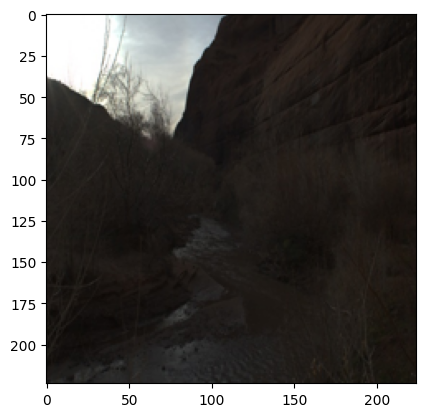

In [46]:
plt.imshow(i[0].permute(1, 2, 0))

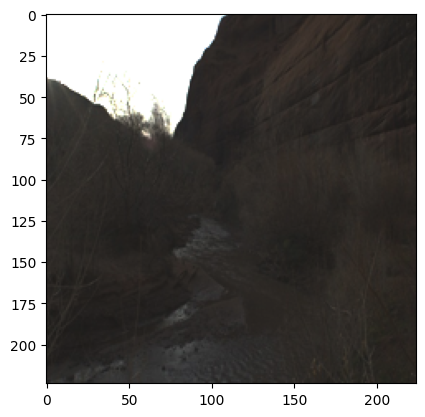

In [47]:
plt.imshow(output[0].permute(1,2,0).cpu())

In [51]:
!pip install numpy opencv-python scipy scikit-image


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 MB 142.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 136.2 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.5/313.5 kB 201.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.9/225.9 kB 193.8 MB/s eta 0:00:00


In [52]:
import cv2
import numpy as np
from scipy.ndimage import gaussian_filter
from skimage import exposure
from sklearn.decomposition import PCA

In [55]:
import cv2
import numpy as np
from scipy.ndimage import gaussian_filter
from skimage import exposure
from sklearn.decomposition import PCA

def extract_features(image_path):
    # Load the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Resize image so the long edge is 500 pixels
    h, w, _ = image.shape
    scale = 500.0 / max(h, w)
    image = cv2.resize(image, (int(w * scale), int(h * scale)))
    
    # Compute log intensity
    log_intensity = np.log1p(image.sum(axis=2))
    
    # Compute mean and percentiles of log intensity
    mean_log_intensity = np.mean(log_intensity)
    percentiles_log_intensity = np.percentile(log_intensity, np.arange(0, 102, 2))
    
    # Gaussian filters
    gaussian_10 = gaussian_filter(log_intensity, sigma=10)
    gaussian_30 = gaussian_filter(log_intensity, sigma=30)
    
    percentiles_gaussian_10 = np.percentile(gaussian_10, np.arange(0, 102, 2))
    percentiles_gaussian_30 = np.percentile(gaussian_30, np.arange(0, 102, 2))
    
    # Compute scene brightness
    median_intensity = np.median(image.sum(axis=2) / 3)
    # Assume N, t, ISO for the example (these should come from EXIF)
    N = 1.0  # Aperture
    t = 1.0  # Exposure duration
    ISO = 100.0  # Sensor gain
    scene_brightness = (median_intensity * (N ** 2)) / (t * ISO)
    
    # Histogram equalization curve
    cdf, _ = exposure.cumulative_distribution(log_intensity.flatten())
    pca = PCA(n_components=min(5, len(cdf)))
    pca_cdf = pca.fit_transform(cdf.reshape(-1, 1)).flatten()
    
    # Detail-weighted equalization curves
    gradient = np.gradient(log_intensity)
    gradient_magnitude = np.sqrt(gradient[0]**2 + gradient[1]**2)
    
    weighted_cdf, _ = exposure.cumulative_distribution((log_intensity * gradient_magnitude).flatten())
    pca_weighted_cdf = pca.fit_transform(weighted_cdf.reshape(-1, 1)).flatten()
    
    # Highlight clipping
    sorted_intensities = np.sort(log_intensity.flatten())
    clip_percentages = [1, 2, 3, 5, 10, 15]
    clip_values = [sorted_intensities[int(len(sorted_intensities) * (1 - p / 100))] for p in clip_percentages]
    
    # Spatial distributions
    features = []
    intensity_range = np.linspace(0, 255, 11)
    for i in range(10):
        mask = (image >= intensity_range[i]) & (image < intensity_range[i + 1])
        coords = np.column_stack(np.nonzero(mask))
        if len(coords) > 0:
            mean_y, mean_x = coords.mean(axis=0)
            cov = np.cov(coords, rowvar=False)
            area = np.pi * np.sqrt(np.linalg.det(cov))
            features.append(area / len(coords))
            features.append(mean_x / w)
            features.append(mean_y / h)
    
    return {
        "mean_log_intensity": mean_log_intensity,
        "percentiles_log_intensity": percentiles_log_intensity,
        "percentiles_gaussian_10": percentiles_gaussian_10,
        "percentiles_gaussian_30": percentiles_gaussian_30,
        "scene_brightness": scene_brightness,
        "pca_cdf": pca_cdf,
        "pca_weighted_cdf": pca_weighted_cdf,
        "clip_values": clip_values,
        "spatial_distributions": features
    }


features = extract_features('../src/sample_images/a0676-kme_609_original.jpg')
print(features)

ValueError: n_components=5 must be between 0 and min(n_samples, n_features)=1 with svd_solver='covariance_eigh'